In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from typing import Union
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

from itertools import product


import torch
from torchmetrics.regression import MeanAbsoluteError
from torchmetrics import MeanAbsolutePercentageError



np.random.seed(42)

In [22]:
df = pd.read_csv('./data/jj.csv')
df.head(5)

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [23]:
df.date.min(), df.date.max()

('1960-01-01', '1980-10-01')

In [24]:
df.shape

(84, 2)

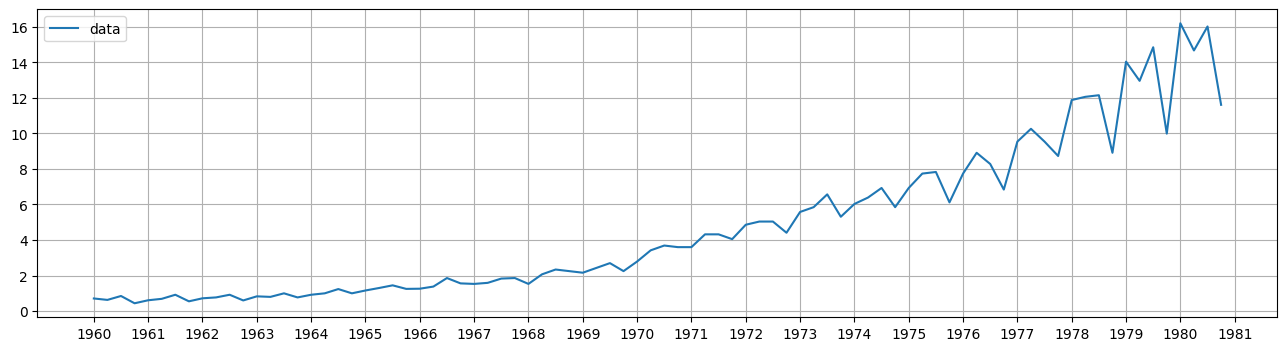

In [25]:
ax = df.plot( figsize=(16,4))
ax.set_xticks( np.arange(0, 88, 4), np.arange(1960, 1982, 1) )
ax.grid()

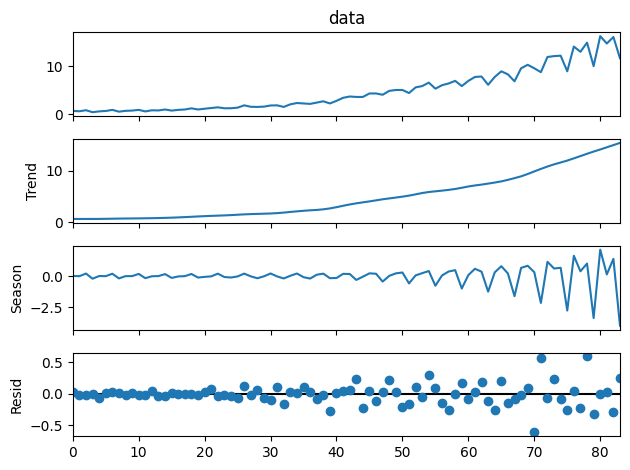

In [93]:
STL(df.data, period=4).fit().plot()
plt.show()

In [106]:
d = 1
df_diff = np.diff(df.data, n=d)
ad_fuller_result = adfuller(df_diff)
ad_fuller_result

(-0.40740976363803183,
 0.9088542416911329,
 10,
 72,
 {'1%': -3.524624466842421,
  '5%': -2.9026070739026064,
  '10%': -2.5886785262345677},
 89.2131713403821)

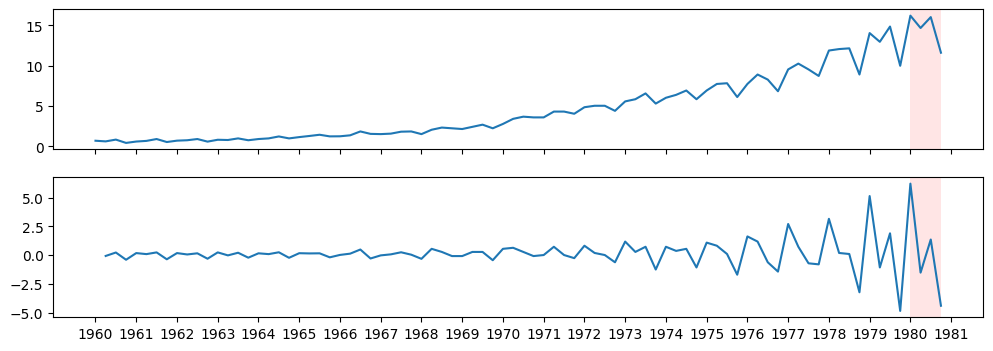

In [107]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
ax1.plot(df.data )
ax1.axvspan(80, 83, facecolor='red', alpha=0.1)
ax1.set_xticks( np.arange(0, 88, 4), np.arange(1960, 1982, 1) )
a = pd.DataFrame(df_diff)
a.index = a.index + d
ax2.plot(a)
ax2.axvspan(80, 83, facecolor='red', alpha=0.1)

plt.show()

In [34]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, isSeasonal: bool, D = 0, s = 0) -> pd.DataFrame:
    
    results = []

    
    for order in tqdm_notebook(order_list):
        if(isSeasonal == True):
            try: 
                model = SARIMAX(
                    endog, 
                    order=(order[0], d, order[1]),
                    seasonal_order=(order[2], D, order[3], s),
                    simple_differencing=False).fit(disp=False)
            except:
                continue
        else:
            try: 
                model = SARIMAX(
                    endog, 
                    order=(order[0], d, order[1]), 
                    simple_differencing=False).fit(disp=False)
            except:
                continue
            
        aic = model.aic
        results.append([order, aic])



    
    result_df = pd.DataFrame(results)
    
    result_df.columns = ['(p,q,P,Q)', 'AIC'] if isSeasonal else ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [48]:
train = df[:-4]
test = df[-4:]
test['naive_seasonal'] =  df.data[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [98]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)


SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 4

SARIMA_result_df = optimize_SARIMA(train.data, SARIMA_order_list, d, True, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 0, 2, 1)",88.829330
1,"(1, 2, 0, 0)",89.609996
2,"(3, 1, 0, 0)",89.677549
3,"(1, 3, 0, 0)",89.734025
4,"(3, 3, 1, 3)",90.170090
...,...,...
251,"(0, 0, 3, 2)",136.749270
252,"(0, 0, 2, 3)",136.768693
253,"(0, 0, 0, 0)",137.133568
254,"(0, 0, 1, 3)",137.761947


In [99]:
SARIMA_model = SARIMAX(train.data, order=(3,1,0), seasonal_order=(2,1,2,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                   data   No. Observations:                   80
Model:             SARIMAX(3, 1, 0)x(2, 1, [1, 2], 4)   Log Likelihood                 -38.641
Date:                                Thu, 15 Aug 2024   AIC                             93.281
Time:                                        09:47:30   BIC                            111.821
Sample:                                             0   HQIC                           100.684
                                                 - 80                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8178      0.129     -6.318      0.000      -1.072      -0.564
ar.

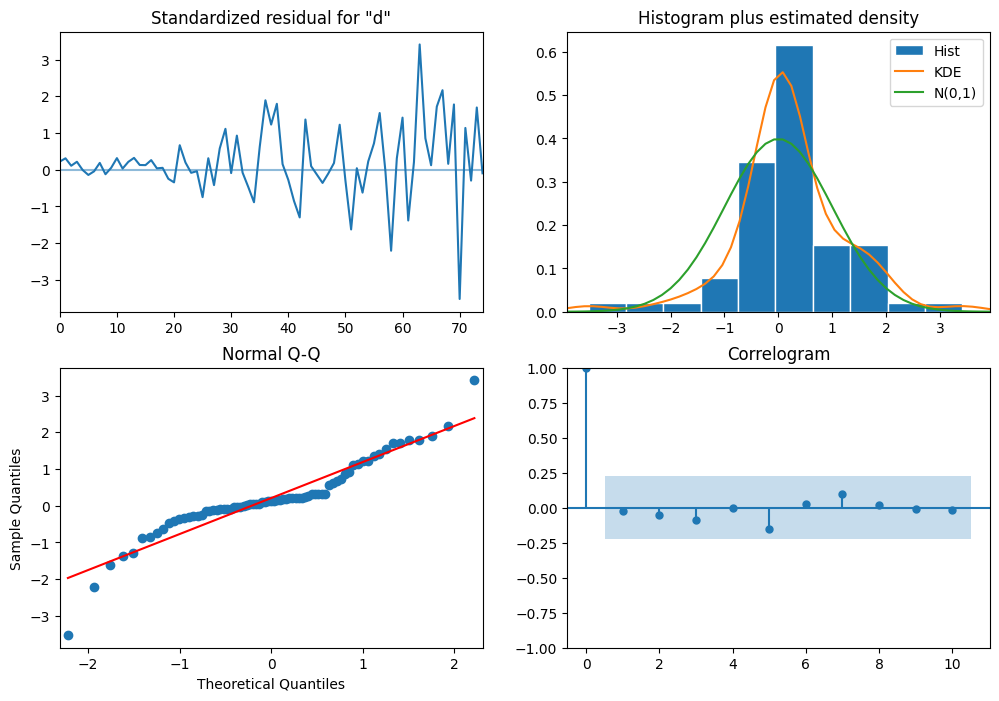

In [53]:
SARIMA_model_fit.plot_diagnostics(figsize=(12,8))
plt.show()

In [54]:
residuals = SARIMA_model_fit.resid
tr = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(tr)

     lb_stat  lb_pvalue
1   0.060014   0.806473
2   0.195895   0.906696
3   1.127709   0.770390
4   1.161549   0.884388
5   2.863870   0.720963
6   2.961880   0.813616
7   3.814916   0.800832
8   3.870100   0.868649
9   3.875633   0.919406
10  3.898008   0.951831


In [63]:
test['SARIMA_pred'] = SARIMA_model_fit.get_prediction(80, 83).predicted_mean
test

,date,data,naive_seasonal,SARIMA_pred
80,1980-01-01,16.20,14.04,16.529647
81,1980-04-01,14.67,12.96,14.099150
82,1980-07-02,16.02,14.85,17.284247
83,1980-10-01,11.61,9.99,11.383886


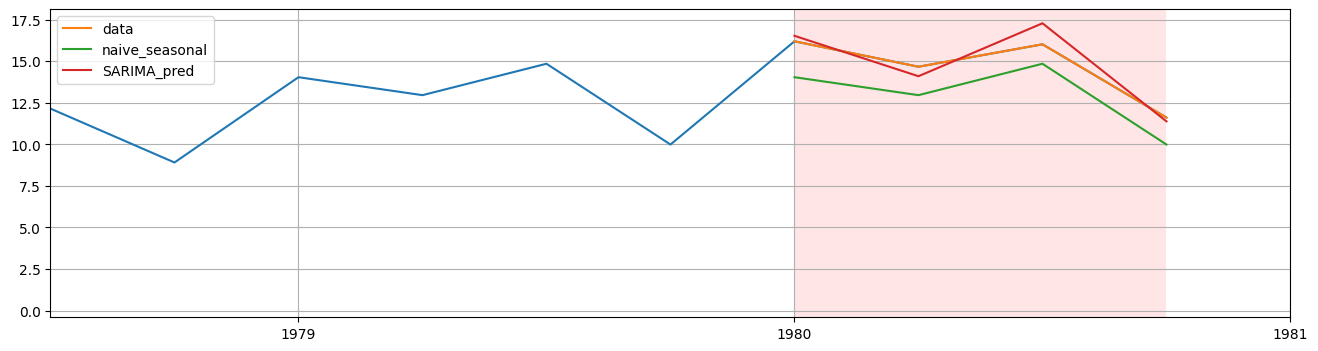

In [71]:
ax = df.data.plot( figsize=(16,4),  layout='constrained' )
ax.axvspan(80, 83, facecolor='red', alpha=0.1)
ax.set_xticks( np.arange(0, 88, 4), np.arange(1960, 1982, 1) )
ax.set_xlim(74, 84)
test.plot( ax = ax)
ax.grid()
plt.show()

In [64]:
mean_absolute_error = MeanAbsoluteError()

maes = {}

pred_naive_seasonal = torch.FloatTensor( test['naive_seasonal'].values)
predict_SARIMA = torch.FloatTensor( test['SARIMA_pred'].values)
target = torch.FloatTensor(test['data'].values)


maes['mae_naive_seasonal'] =  mean_absolute_error( pred_naive_seasonal, target ).item()
maes['mae_SARIMA'] = mean_absolute_error( predict_SARIMA, target ).item()
maes

{'mae_naive_seasonal': 1.6650002002716064, 'mae_SARIMA': 0.5977134704589844}

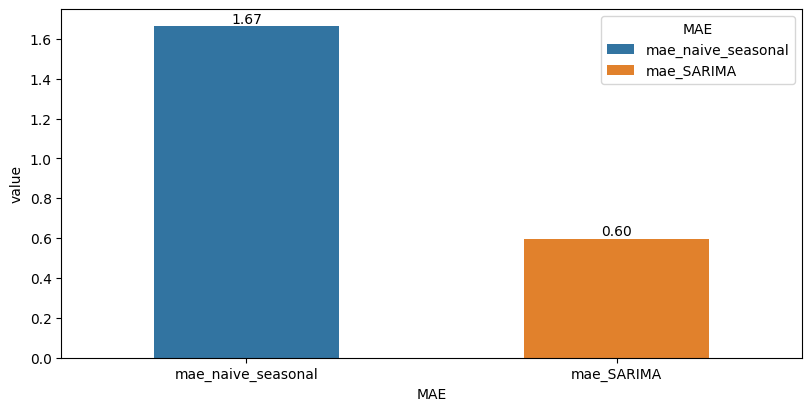

In [65]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([maes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )

ax.set_xlabel('MAE')
ax.legend(title='MAE')
for index, label in enumerate(maes):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

In [67]:
mean_abs_percentage_error = MeanAbsolutePercentageError()
mapes = {}

pred_naive_seasonal = torch.FloatTensor( test['naive_seasonal'].values)
predict_SARIMA = torch.FloatTensor( test['SARIMA_pred'].values)
target = torch.FloatTensor(test['data'].values)

mapes['mape_naive_seasonal'] = mean_abs_percentage_error( pred_naive_seasonal, target).item()
mapes['mape_SARIMA'] = mean_abs_percentage_error( predict_SARIMA, target ).item()
mapes

{'mape_naive_seasonal': 0.11561658978462219,
 'mape_SARIMA': 0.03941341117024422}

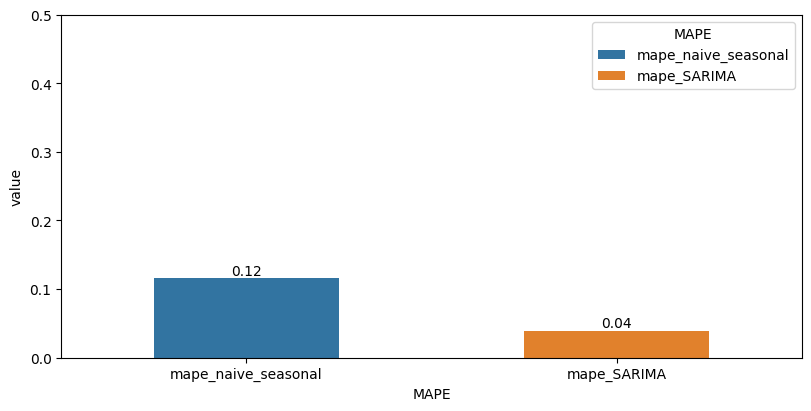

In [68]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([mapes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )
ax.set_ylim(0, 0.5)
ax.set_xlabel('MAPE')
ax.legend(title='MAPE')
for index, label in enumerate(mapes):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)